# Autoregressive Sequence Prediction with an $n$-th Order Linear Markov Model
An $n$th order Markov model is one in which the value of a token $x_t$ is assumed to depend only on the $n$ preceding terms. In other words:
$$P(x_t|x_{t-1},\dots,x_1)=P(x_t|x_{t-1},\dots,x_{t-n})$$

In this notebook, we generate a noisy sinusoidal dataset and train a linear model to predict the next token, using the previous 4 tokens. We then use the model autoregressively to test how its accuracy diminishes as more terms are generated.

This is an implementation of the code from section 9.1 of Dive into Deep Learning by Zhang et al.


In [28]:
import torch
import torch.nn as nn
import torch.utils.data as data
from tqdm.auto import tqdm

In this section we are creating some noisy sinusoidal data and trying to predict the $n$ th token from the $\tau$ preceding tokens. This class is our own custom object which will create a sequence with random noise when the class is instantiated. We define a a `get_dataloader` method which will return a generator object when called, which can be iterated over and produces batches. I name the dataset `seq` because it's a sequence.

In [29]:
class Data():

  def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
    self.time = torch.arange(1, T+1, dtype=torch.float32) # This is a tensor containing the 'time step' for each token
    self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2 # This is our sequence of tokens
    self.batch_size = batch_size
    self.T = T
    self.tau = tau
    self.num_train = num_train

  def get_dataloader(self, train): #train = True/False (you need to specify if this is training data or not)
    features = [self.x[i: self.T-self.tau+i] for i in range(self.tau)] # Collecting tau lists of tokens, each with length self.T-self
    self.features = torch.stack(features, 1) # Stacking lists to create a tensor of self.T-self sequences, each containing tau tokens
    self.labels = self.x[self.tau:].reshape((-1,1)) # Creating a tensor containing the n+1 th token for each sequence. (To be predicted from each of the tau tokens preceding it)
    indices = slice(0, self.num_train) if train else slice(self.num_train, None) # Creates sets of indices based on whether data is for training/testing
    tensors = tuple(a[indices] for a in [self.features, self.labels]) # Selects wanted portion of the data (train or test)
    dataset = torch.utils.data.TensorDataset(*tensors) # Turns tensors into dataset object, the *tensor means it passes each of self.features, self.labels individually
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train) # Creates dataloader object which can be used to load a batch of data

In [30]:
seq = Data() # Creating dataset object
train_loader = seq.get_dataloader(True) # Creating training dataloader object
test_loader = seq.get_dataloader(False) # Creating testing dataloader object

Text(0, 0.5, 'x')

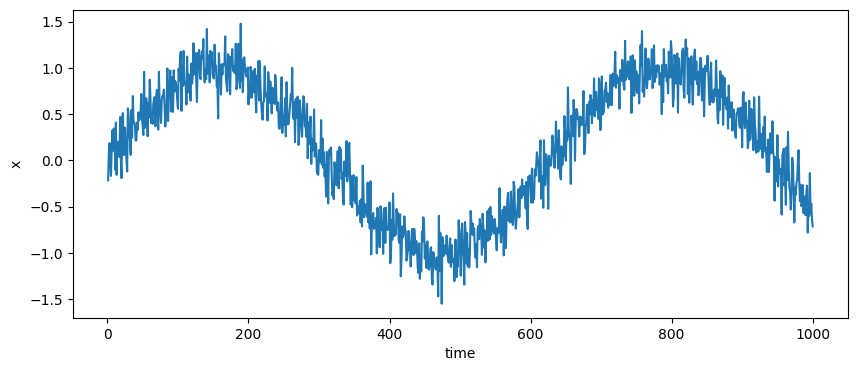

In [31]:
# Visualising the sequence data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(seq.time, seq.x)
plt.xlabel("time")
plt.ylabel("x")

## Prediction with a simple linear model
Uisng linear regression here. This can be more efficiently implemented with something like scipy or scikit-learn but I wanted to use PyTorch for practice.

In [32]:
# Create linear model class ===================================
class LinearRegression(nn.Module):
  def __init__(self, tau):
    super().__init__()
    self.linear = nn.Linear(tau,1)

  def forward(self, x):
    return self.linear(x)

# Instantiate model
model = LinearRegression(tau=seq.tau)

# Set optimizer, loss function
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Training stage
epochs = 5

for epoch in tqdm(range(epochs)):
  train_loss = 0
  test_loss = 0
  train_len = len(train_loader)
  test_len = len(test_loader)

  # Train step
  model.train()
  for batch, (X,y) in enumerate(train_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss/train_len
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Training loss: {train_loss}")

  # Test step
  model.eval()
  for batch, (X,y) in enumerate(test_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    test_loss += loss/test_len
  print(f"Testing loss: {test_loss}")
# =======================================================

  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.08930335938930511
Testing loss: 0.05715791881084442
Training loss: 0.05575534328818321
Testing loss: 0.052908752113580704
Training loss: 0.05175568163394928
Testing loss: 0.050916723906993866
Training loss: 0.049302395433187485
Testing loss: 0.049603525549173355
Training loss: 0.04816223680973053
Testing loss: 0.052424944937229156


# 1-step Predictions
Now we've trained the basic model, we can try seeing how it performs. We are going to predict the following term for each sequence


Text(0.5, 1.0, '1-Step Predictions')

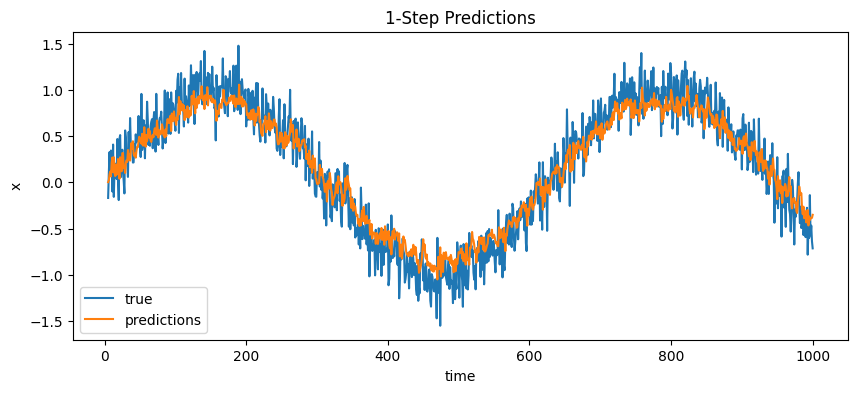

In [54]:
preds = model(seq.features).detach()
plt.figure(figsize=(10, 4))
plt.plot(seq.time[seq.tau:], seq.labels.squeeze(), label="true")
plt.plot(seq.time[seq.tau:], preds.squeeze(), label="predictions")
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.title("1-Step Predictions")

# k-step predictions
We will now apply the model $k$ times to find out the $k$th term after each $\tau$-length sequence.

In [34]:
def k_step_preds(k):
  features = []
  for i in range(seq.tau):
    features.append(seq.x[i:i+seq.T-seq.tau]) # Create tau sequences, each of length seq.T-seq.tau, each one starts one token ahead of the previous. Stacking them along dim 1 creates a sample of length tau
  for i in range(k):
    preds = model(torch.stack(features[i : i+seq.tau], 1)) # Create another sequence corresponding to the next element in the sequence. This element is predicted using the previous tau tokens
    features.append(preds.reshape(-1)) #Append the sequence to the features list
  return features[seq.tau:] #Return all generated predictions (not those from the first )

new_preds = k_step_preds(100)

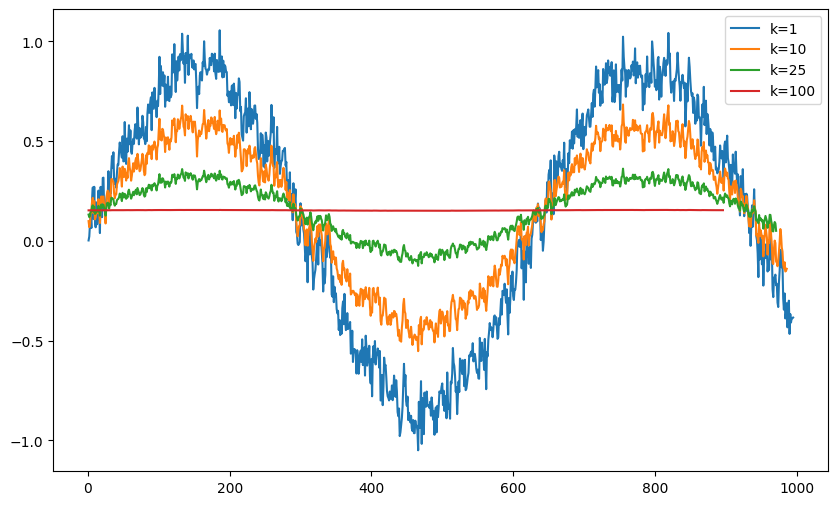

In [53]:
plt.figure(figsize=(10,6))
k_vals = [1, 10, 25, 100]
for k in k_vals:
  plt.plot(seq.time[:seq.T-seq.tau-k].detach(), new_preds[k-1][:seq.T-seq.tau-k].detach(), label=f"k={k}")
plt.legend()
plt.title("K-step Sequence Predictions")

Clearly there is a severe cost in the accuracy as we increase the value of k. As the model is predictions are used over and over to produce more predictions, the errors compound and the accuracy plummets.